# MNIST dataset을 이용한 분류

In [1]:
# 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'Malgun Gothic'  # 'NanumGothic' 폰트 사용
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

## 1. dataset 내려받기

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)   # as_frame=False: 넘파이 배열로 데이터 반환

## 2. data 나누기(data/target, train/test)

In [3]:
# data/target 데이터 나누기
X, y = mnist.data, mnist.target

In [4]:
# data
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [5]:
# data.shape
X.shape   # 이미지 70000개, 28x28개의 특성

(70000, 784)

In [6]:
# target
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

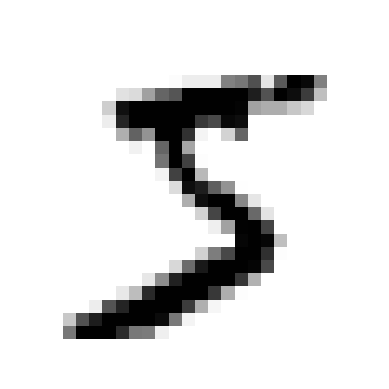

In [7]:
# dataset에서 이미지 하나 확인
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)   # 28x28의 2차원 배열로 변환
    plt.imshow(image, cmap="binary")   # cmap="binary": 이미지가 흑백으로 표시
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
# 실제 label 확인
y[0]

'5'

In [9]:
# train/test 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3. 이진 분류기 훈련

'5'와 '5 아님' 두 개의 class를 구분할 수 있는 이진 분류기

In [10]:
# 타깃벡터 만들기
y_train_5 = (y_train=='5')   # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test=='5')

In [11]:
# SGD(확률적 경사 하강법)Classifier model 이용 및 학습
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
# 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

## 4. 성능 측정

In [13]:
# k-fold cross validation을 이용하여 SGDClassifier 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()   # 가장 빈번하게 등장하는 class로 분류(여기서는 '5 아님')
dummy_clf.fit(X_train, y_train_5)
# False가 출력. 즉, True로 예측된 것이 x
print(any(dummy_clf.predict(X_train)))

False


In [15]:
# cross_val_predict(): k-fold cross validation을 수행하지만 평가 점수를 반환x, 각 테스트 폴드에서 얻은 예측을 반환
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
# confusion matrix 만들기
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### 정밀도, 재현율, f1-score

In [17]:
# 정밀도 재현율 계산
from sklearn.metrics import precision_score, recall_score
print(f"정밀도: {precision_score(y_train_5, y_train_pred)}\n재현율: {recall_score(y_train_5, y_train_pred)}")

정밀도: 0.8370879772350012
재현율: 0.6511713705958311


In [18]:
# f1-score 계산
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [19]:
# decision_function(): 결정함수 구하기
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
# 임곗값(threshold) 설정을 통해 예측 만들기
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

-> SGDClassifier의 임곗값이 0으로 predict() 메서드와 같은 결과, True를 반환

In [21]:
# 임곗값 높이기
threshold = 3000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

-> 임곗값을 높이면 재현율이 줄어드는 것을 볼 수 있음

### 적절한 임곗값 정하기

In [22]:
# cross_val_predict() + method="decision_function": 훈련 세트에 있는 모든 샘플의 점수 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [23]:
# precision_recall_curve: 가능한 모든 임곗값에 대해 정밀도와 재현율 계산\
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

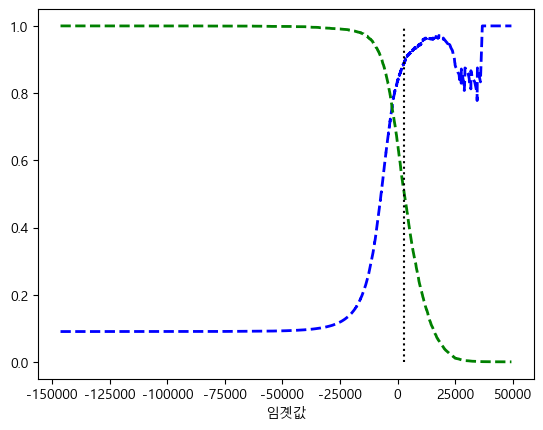

In [24]:
# 1. 임곗값의 함수로 정밀도와 재현율 시각화
plt.plot(thresholds, precisions[:-1], "b--", label="정밀도", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g--", label="재현율", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="임곗값")   # 임곗값=3000일 때
plt.xlabel("임곗값")
plt.show()

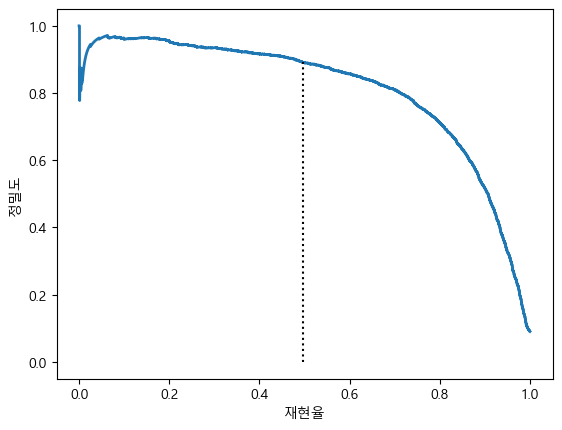

In [25]:
# 2. 재현율에 대한 정밀도 곡선 시각화하여 결정하기
import numpy as np
plt.plot(recalls, precisions, linewidth=2, label="정밀도/재현율 곡선")

# threshold에 해당하는 정밀도와 재현율 찾기
precision_at_threshold = precisions[np.argmax(thresholds >= threshold)]
recall_at_threshold = recalls[np.argmax(thresholds >= threshold)]

# 임곗값을 나타내는 직선 그리기 (재현율 값에 대응하는 정밀도)
plt.vlines(recall_at_threshold, 0, precision_at_threshold, color="k", linestyle="dotted", label="임곗값")
plt.xlabel("재현율")
plt.ylabel("정밀도")
plt.show()

In [26]:
# ex) 정밀도 90%를 달성하는 것이 목표라고 가정 -> 정밀도가 최소 90%가 되는 가장 낮은 임곗값을 찾기
# argmax(): 최댓값의 첫 번째 인덱스 반환 -> 첫 번째 True값을 의미

idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [27]:
# 훈련 set에 대한 예측을 만들려면 분류기의 predict() 대신 다음 코드 실행
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [28]:
# 해당 예측에 대한 정밀도와 재현율 확인
print("정밀도:", precision_score(y_train_5, y_train_pred_90))
print("재현율:", recall_score(y_train_5, y_train_pred_90))

정밀도: 0.9000345901072293
재현율: 0.4799852425751706


### ROC 곡선

In [29]:
# roc_curve(): 여러 임곗값에서 TPR, FPR 계산
from sklearn.metrics import roc_curve

fpr, tpr, thresholds, = roc_curve(y_train_5, y_scores)

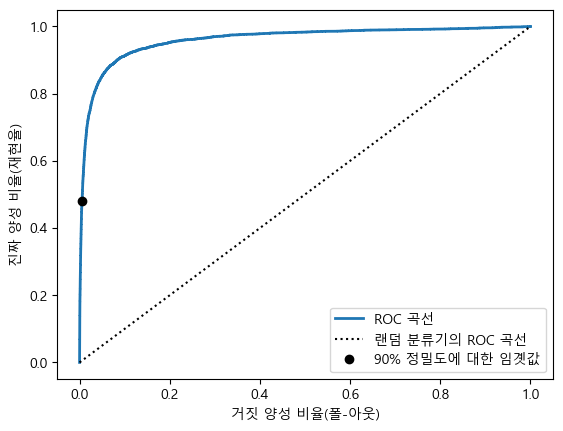

In [30]:
# TPR에 대한 FPR 곡선 나타기기
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC 곡선")
plt.plot([0, 1], [0, 1], 'k:', label="랜덤 분류기의 ROC 곡선")
plt.plot([fpr_90], [tpr_90], 'ko', label="90% 정밀도에 대한 임곗값")
plt.xlabel("거짓 양성 비율(폴-아웃)")
plt.ylabel("진짜 양성 비율(재현율)")
plt.legend()
plt.show()

### AUC: 곡선 아래의 면적

In [31]:
# ROC의 AUC를 계산하는 함수
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
# RandomForestClassifier 이용하여 SGDClassifier의 PR 곡선과 F1 점수 비교
# RandomForestClassifier 정의
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [33]:
# cross_val_predict(): 교차 검증으로 훈련, 모든 sample에 대한 class 확률 예측
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")   # predict_proba(): 각 sample에 대한 class 확률 반환

In [34]:
# 훈련 set의 처음 2개의 이미지에 대한 class 확률
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [35]:
# precision_recall_curve(): 가능한 모든 임곗값에 대해 정밀도, 재현율 계산
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

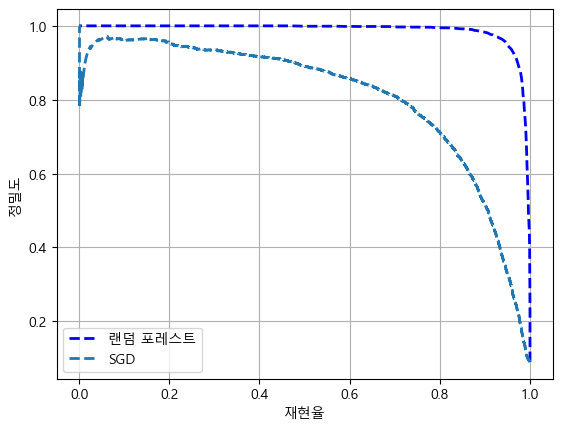

In [36]:
# PR 곡선 시각화
plt.plot(recalls_forest, precisions_forest, "b--",linewidth=2, label="랜덤 포레스트")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("재현율")
plt.ylabel("정밀도")
plt.grid(True)
plt.legend()
plt.show()

-> 랜덤 포레스트 분류기가 SGD 분류기보다 성능이 좋음  
랜덤 포레스트의 PR 곡선이 오른쪽 위 ㅣ목소리에 훨씬 가까워 AUC가 더 높기 때문

In [37]:
# 이진 분류 문제에서 임곗값을 0.5로 설정하여 양성 클래스(1)로 분류할지 결정
# f1 score, AUC 점수 확인
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5   # 양성 클래스 확률 >= 50%
print(f"f1_score: {f1_score(y_train_5, y_train_pred_forest)}\nAUC: {roc_auc_score(y_train_5, y_scores_forest)}")

f1_score: 0.9274509803921569
AUC: 0.9983436731328145


## 5. 다중 분류

In [38]:
# svm 분류기를 이용해 다중 분류
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])   # y_train_5가 아닌 y_train을 사용

SVC(random_state=42)

In [39]:
# 한 이미지에 대한 예측
svm_clf.predict([some_digit])

array(['5'], dtype=object)

-> 정답, 클래스 쌍마다 하나씩 45번의 예측을 수행하여 가장 많은 쌍에서 승리한 클래스를 선택하였음

In [40]:
# decision_function() -> sample마다 총 10개의 점수(클래스마다 하나씩) 반환
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [41]:
class_id = some_digit_scores.argmax()
class_id

5

-> 가장 높은 점수는 9.3, 이는 클래스 5에 해당

In [42]:
# classes_: 타깃 클래스의 리스트를 값으로 정렬하여 저장
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [43]:
svm_clf.classes_[class_id]

'5'

In [44]:
# SVC 기반으로 OVR 전략을 사용하는 다중 분류기 -> OVC&OVR을 사용하도록 강제하기 위해 OneVsOneClassifier&OneVsRestClassifier 사용
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [45]:
# 훈련된 분류기 개수 확인
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)   # 분류기 개수

10

In [46]:
# 다중 분류 데이터셋에서 SGDClassifier 이용
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

-> 예측 오류, 사이킷런이 OvR 전략을 사용

In [47]:
# decision_function()을 이용하여 SGD 분류기가 각 클래스에 부여한 점수를 확인
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [48]:
# cross_val_score()을 이용하여 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [49]:
# 입력의 scaling을 통해 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 6. 오류 분석

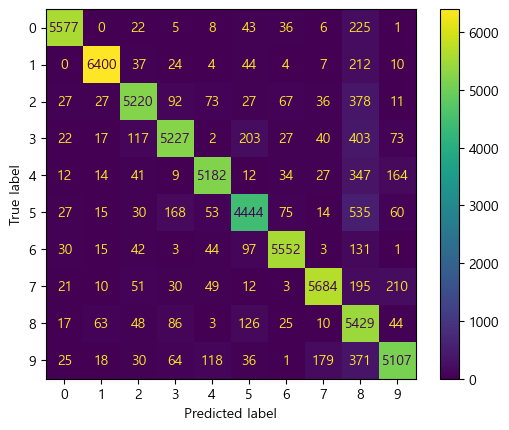

In [50]:
# ConfusionMatrixDisplay.from_predictions(): 오차 행렬을 컬러 그래프로 나타내기
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

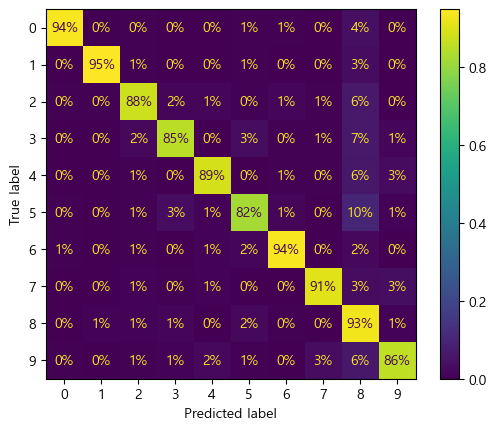

In [51]:
# 오차 행렬을 정규화
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true",   # 오차 행렬 정규화
                                        values_format=".0%")   # 소수점 없이 백분율로 표시
plt.show()

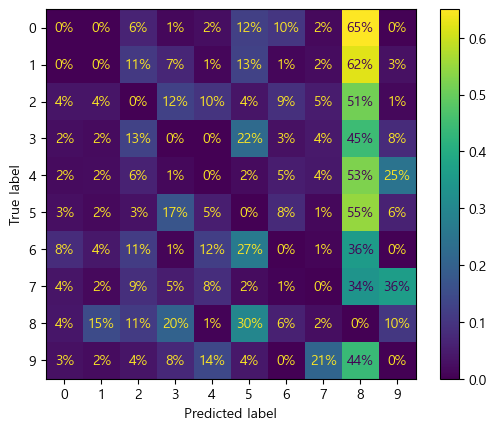

In [52]:
# 오류를 더 눈에 띄게 만들기 -> 올바른 예측에 대한 가중치를 0으로 설정
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true",
                                        values_format=".0%")
plt.show()

## 7. 다중 레이블 분류

In [53]:
# 두 개의 target label이 담긴 y_multilabele 배열 만들기
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')   # 숫자가 큰 값(7, 8, 9)인지
y_train_odd = (y_train.astype('int8') % 2 == 1)   # 홀수인지
y_multilabel = np.c_[y_train_large, y_train_odd]   # 열 방향으로 합치기

# KNeighborsClassifier model 이용
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [54]:
# 예측
knn_clf.predict([some_digit])

array([[False,  True]])

In [55]:
# 다중 레이블 분류기 평가 -> 모든 레이블에 대한 f1-score의 평균 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [56]:
# ClassifierChain: 다중 레이블 분류를 지원하지 않는 분류기를 사용할 때 이용
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)   # cv를 지정함으로써 교차 검증
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [57]:
# 예측
chain_clf.predict([some_digit])

array([[0., 1.]])

## 8. 다중 출력 분류

In [58]:
# 이미지 픽셀 강도에 잡음 추가
np.random.seed(42)   # 동일하게 재현되도록 지정
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

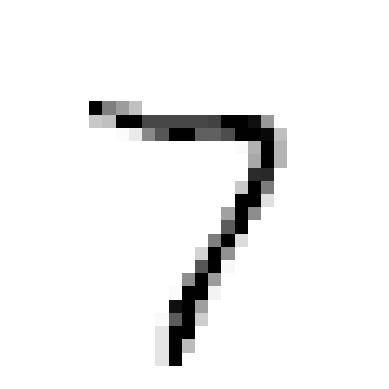

In [59]:
# 분류기를 훈련하여 이미지를 깨끗하게 만기기
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()